# 03 — Model Training, Evaluation & Model Selection

This notebook trains and compares multiple regression models to predict  
**hospital length of stay (`time_in_hospital`)** for diabetic patients.

We use both linear and tree-based ensemble methods, apply cross-validation,  
and perform hyperparameter tuning to select a robust final model.

---

### 🎯 Objectives

1. Load the processed dataset and prepare features/target  
2. Train baseline models (Linear, Ridge, Lasso, Random Forest, AdaBoost, XGBoost, LightGBM, CatBoost)  
3. Evaluate models using 5-fold cross-validation (R², RMSE, MAE)  
4. Tune top-performing models with GridSearchCV / RandomizedSearchCV  
5. Compare tuned models and select a **final model** (LightGBM)


## 1️⃣ Load Processed Dataset

We start from the cleaned dataset produced in `02_data_preprocessing.ipynb`,  
which contains engineered features and one-hot encoded categorical variables.

A quick preview confirms the shape and structure of the data.


In [1]:
import os
import numpy as np
import pandas as pd

PROC_PATH = "../data/processed/cleaned_data.csv"
df = pd.read_csv(PROC_PATH)
print("Loaded:", df.shape)
df.head(3)


Loaded: (101766, 291)


,time_in_hospital,payer_code,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,metformin,...,admission_source_id_20,admission_source_id_22,admission_source_id_25,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9
0,1,Unknown,41,0,1,0,0,0,1,No,...,False,False,False,False,False,False,False,False,False,False
1,3,Unknown,59,0,18,0,0,0,9,No,...,False,False,False,False,False,False,False,True,False,False
2,2,Unknown,11,5,13,2,0,1,6,No,...,False,False,False,False,False,False,False,True,False,False


## 2️⃣ Prepare Feature Matrix for Modeling

Even after preprocessing, we ensure the feature matrix is strictly numeric and clean:

- Convert any residual `object`/`bool` columns (e.g. encoded flags) into numeric form  
- Sanitize column names for compatibility with libraries like XGBoost/LightGBM  
- Confirm there are no remaining missing values

> This step guarantees compatibility with scikit-learn and gradient boosting libraries.


In [2]:
from pandas.api.types import is_object_dtype

TARGET = "time_in_hospital"
assert TARGET in df.columns, "Target missing."

df_model = df.copy()

# If payer_code is non-numeric, drop for baseline (to keep matrix purely numeric)
if "payer_code" in df_model.columns and not np.issubdtype(df_model["payer_code"].dtype, np.number):
    df_model = df_model.drop(columns=["payer_code"])

# Fill any residual NaNs numerically
df_model = df_model.fillna(0)

print("After cleaning -> shape:", df_model.shape)
print("Remaining NaNs:", int(df_model.isna().sum().sum()))


After cleaning -> shape: (101766, 290)
Remaining NaNs: 0


In [3]:
# Encode any remaining object/bool columns (e.g., drug columns with 'No/Steady/Up/Down')
from pandas.api.types import is_object_dtype

obj_cols = [c for c in df_model.columns if c != TARGET and is_object_dtype(df_model[c])]
print("Object cols to encode:", len(obj_cols), obj_cols[:10])  # peek

# One-hot encode remaining objects
if obj_cols:
    df_model = pd.get_dummies(df_model, columns=obj_cols, drop_first=True)

# Safety: fill any residual NaNs (should be none after get_dummies)
df_model = df_model.fillna(0)

print("After encoding objects -> shape:", df_model.shape)
print("Remaining NaNs:", int(df_model.isna().sum().sum()))
print("dtypes summary:\n", df_model.dtypes.value_counts())


Object cols to encode: 26 ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone']
After encoding objects -> shape: (101766, 316)
Remaining NaNs: 0
dtypes summary:
 bool       302
int64       10
float64      4
Name: count, dtype: int64


## 3️⃣ Train–Test Split

We split the data into **training** and **test** sets using a fixed random seed  
to ensure reproducibility:

- 80% for training (including cross-validation)  
- 20% held out for final evaluation

The test set is **never used** during model selection or hyperparameter tuning.


In [4]:
from sklearn.model_selection import train_test_split

X = df_model.drop(columns=[TARGET])
y = df_model[TARGET].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train:", X_train.shape, "| X_test:", X_test.shape)
print("y_train:", y_train.shape, "| y_test:", y_test.shape)


X_train: (81412, 315) | X_test: (20354, 315)
y_train: (81412,) | y_test: (20354,)


## 4️⃣ Define Baseline and Ensemble Models

We consider a diverse set of regression models:

- **Linear models:** Linear Regression, Ridge, Lasso  
- **Ensembles (bagging/boosting):** Random Forest, AdaBoost  
- **Gradient boosting models:** XGBoost, LightGBM, CatBoost (if installed)

This mix allows us to compare simple linear baselines with more powerful nonlinear models.


In [5]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "Lasso": Lasso(alpha=1e-3, random_state=42),
    "RF": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    "AdaBoost": AdaBoostRegressor(n_estimators=200, random_state=42),
}

# Optional: XGBoost / LightGBM / CatBoost if installed
try:
    from xgboost import XGBRegressor
    models["XGB"] = XGBRegressor(
        n_estimators=400, learning_rate=0.1, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    )
    print("XGBoost available.")
except Exception as e:
    print("XGBoost not available:", e)

try:
    from lightgbm import LGBMRegressor
    models["LGBM"] = LGBMRegressor(
        n_estimators=400, learning_rate=0.05, num_leaves=31,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    )
    print("LightGBM available.")
except Exception as e:
    print("LightGBM not available:", e)

try:
    from catboost import CatBoostRegressor
    models["CatBoost"] = CatBoostRegressor(
        iterations=400, learning_rate=0.05, depth=6, verbose=False, random_state=42
    )
    print("CatBoost available.")
except Exception as e:
    print("CatBoost not available:", e)


XGBoost available.
LightGBM available.
CatBoost available.


In [ ]:
feature_cols = [c for c in df_model.columns if c != TARGET]

for c in feature_cols:
    if df_model[c].dtype == bool:
        df_model[c] = df_model[c].astype(np.uint8)

df_model[feature_cols] = df_model[feature_cols].astype(np.float32)

df_model = df_model.fillna(0)
print("Dtype summary:\n", df_model.dtypes.value_counts())


Dtype summary:
 float32    332
int64        1
Name: count, dtype: int64


## 5️⃣ Model Comparison via 5-Fold Cross-Validation

Each model is evaluated using **5-fold cross-validation** on the training set:

- Metrics: **R²**, **RMSE**, **MAE**  
- Linear models are wrapped in a pipeline with `StandardScaler`  
- Tree-based and boosting models use raw (already scaled/encoded) features

The resulting table ranks models primarily by **RMSE**,  
highlighting top performers for further tuning.


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

def cv_metrics(model, X, y, needs_scaling=False, cv=5):
    est = Pipeline([("scaler", StandardScaler()), ("model", model)]) if needs_scaling else model
    r2 = cross_val_score(est, X, y, cv=cv, scoring="r2")
    rmse = -cross_val_score(est, X, y, cv=cv, scoring="neg_root_mean_squared_error")
    mae = -cross_val_score(est, X, y, cv=cv, scoring="neg_mean_absolute_error")
    return r2.mean(), rmse.mean(), mae.mean()

results = []
for name, mdl in models.items():
    needs_scaling = name in ["Linear", "Ridge", "Lasso"]
    r2, rmse, mae = cv_metrics(mdl, X_train, y_train, needs_scaling=needs_scaling, cv=5)
    results.append({"Model": name, "R2": r2, "RMSE": rmse, "MAE": mae})

cv_df = pd.DataFrame(results).sort_values(by="RMSE", ascending=True).reset_index(drop=True)
cv_df


X_train: (81412, 332) | X_test: (20354, 332)
XGBoost available.
LightGBM available.
CatBoost available.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 65129, number of used features: 298
[LightGBM] [Info] Start training from score 4.400789
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1371
[LightGBM] [Info] Number of data points in the train set: 65129, number of used features: 299
[LightGBM] [Info] Start training from score 4.408835
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing 

,Model,R2,RMSE,MAE
0,RF,0.999675,0.053005,0.004970
1,LGBM,0.998976,0.095446,0.057665
2,XGB,0.998965,0.096110,0.051140
3,CatBoost,0.998577,0.112852,0.071571
4,Lasso,0.708097,1.617381,1.203776
5,Ridge,0.708037,1.617547,1.203223
6,AdaBoost,0.689292,1.666136,1.529536
7,Linear,-6365.962134,116.966712,2.185624


## 6️⃣ Hyperparameter Tuning — Random Forest (GridSearchCV)

Based on cross-validation results, Random Forest is selected for detailed tuning.  
We apply **GridSearchCV** over a range of hyperparameters:

- `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`, `max_features`

The best configuration is chosen by maximizing cross-validated **R²**.


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Parameters grid for Random Forest
rf_param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

# GridSearchCV (5-fold cross-validation)
rf_grid = GridSearchCV(
    estimator=rf_base,
    param_grid=rf_param_grid,
    cv=5,
    scoring="r2",
    verbose=2,
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)

print("✅ Best Parameters:", rf_grid.best_params_)
print("✅ Best CV Score (R²):", rf_grid.best_score_)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
✅ Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
✅ Best CV Score (R²): 0.9286761504960733


In [ ]:
rf_best = rf_grid.best_estimator_

# Test set evaluation
y_pred = rf_best.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print(f"Test R²: {r2:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")


Test R²: 0.9369
Test RMSE: 0.7411
Test MAE: 0.4462


c:\Users\ahmet\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


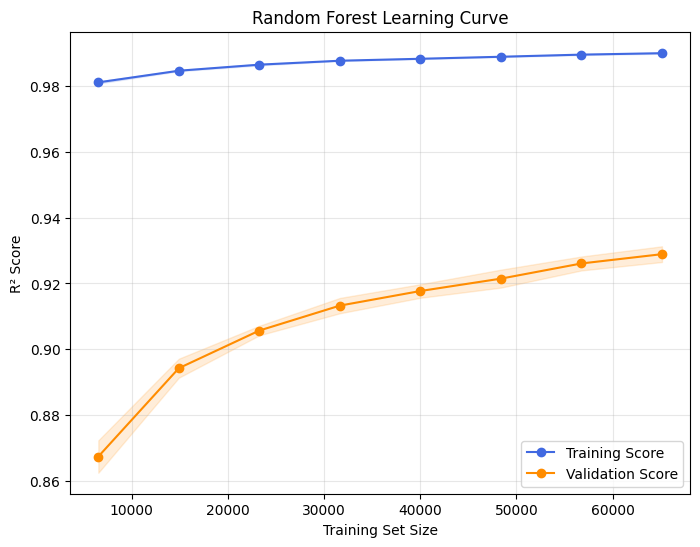

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Learning curve computation
train_sizes, train_scores, val_scores = learning_curve(
    rf_best,
    X_train,
    y_train,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 8),
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, label="Training Score", color="royalblue", marker="o")
plt.plot(train_sizes, val_mean, label="Validation Score", color="darkorange", marker="o")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color="royalblue")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15, color="darkorange")

plt.title("Random Forest Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


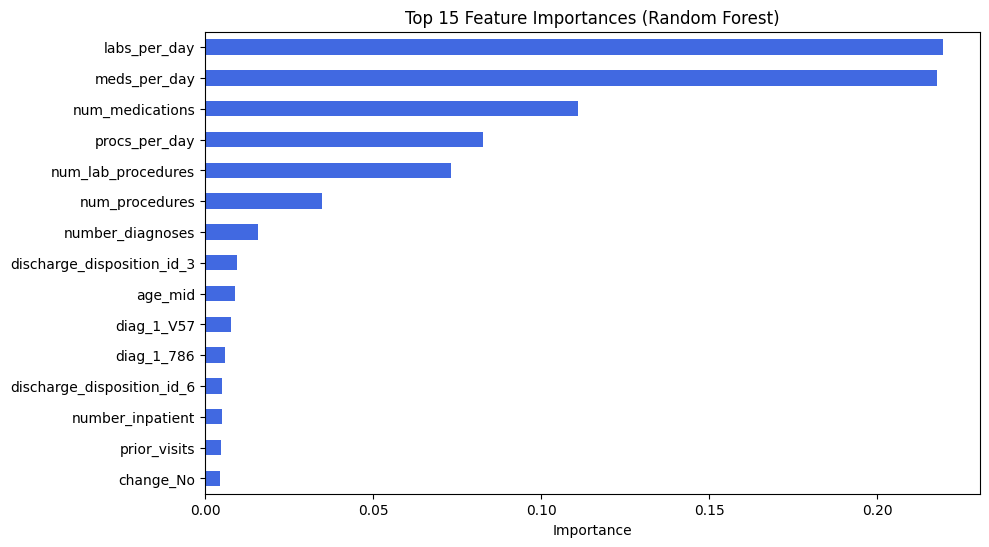

['labs_per_day',
 'meds_per_day',
 'num_medications',
 'procs_per_day',
 'num_lab_procedures',
 'num_procedures',
 'number_diagnoses',
 'discharge_disposition_id_3',
 'age_mid',
 'diag_1_V57',
 'diag_1_786',
 'discharge_disposition_id_6',
 'number_inpatient',
 'prior_visits',
 'change_No']

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Feature importances
importances = pd.Series(rf_best.feature_importances_, index=X_train.columns)
top_features = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10,6))
top_features.plot(kind="barh", color="royalblue")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()

top_features.index.tolist() 

PDP features: ['age_mid', 'num_medications', 'num_lab_procedures', 'number_diagnoses', 'meds_per_day', 'labs_per_day', 'prior_visits', 'gender_Male']


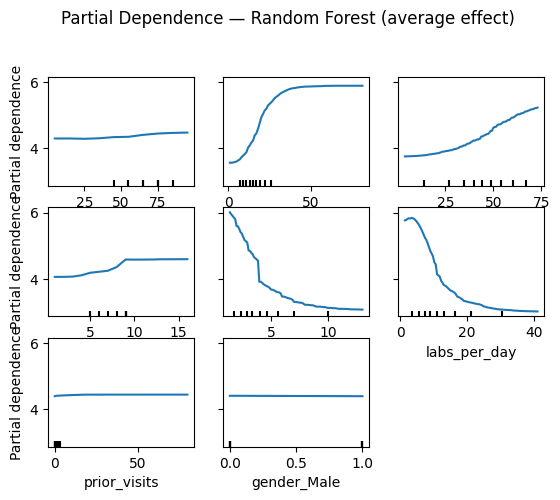

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import numpy as np

# Candidate features for Partial Dependence analysis
candidate_feats = [
    "age_mid",
    "num_medications",
    "num_lab_procedures",
    "number_diagnoses",
    "meds_per_day",
    "labs_per_day",
    "prior_visits",
    "A1Cresult__7",   # sanitized version of ">7"
    "A1Cresult__8",   # sanitized version of ">8"
    "gender_Male"
]

# Select features that exist in the training data
pdp_feats = [c for c in candidate_feats if c in X_train.columns]

# If not enough features found, fill automatically using top importances
if len(pdp_feats) < 4:
    auto_fill = [f for f in importances.sort_values(ascending=False).index if f not in pdp_feats]
    pdp_feats = (pdp_feats + auto_fill)[:4]

print("PDP features:", pdp_feats)

# Plot Partial Dependence (average effects)
fig = PartialDependenceDisplay.from_estimator(
    rf_best,          # fitted Random Forest model
    X_train,
    features=pdp_feats,
    kind="average",   # use "both" for PDP + ICE
    n_jobs=-1
)

fig.figure_.suptitle("Partial Dependence — Random Forest (average effect)", y=1.02)
plt.show()


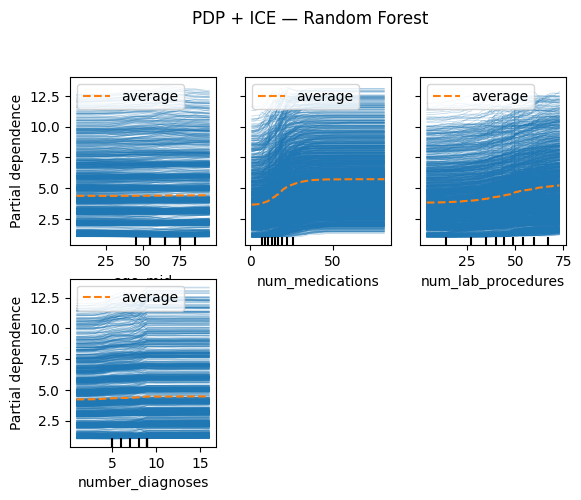

In [ ]:
# Combined Partial Dependence (PDP) + Individual Conditional Expectation (ICE)
fig = PartialDependenceDisplay.from_estimator(
    rf_best,               # fitted Random Forest model
    X_train,
    features=pdp_feats[:4],
    kind="both",           # plot both average (PDP) and individual (ICE) curves
    subsample=2000,        # use subset for faster visualization on large data
    n_jobs=-1
)

fig.figure_.suptitle("PDP + ICE — Random Forest", y=1.02)
plt.show()


## 7️⃣ Hyperparameter Tuning — XGBoost

After evaluating the Random Forest, we now tune a **Gradient Boosting** model (XGBoost).  
RandomizedSearchCV is applied with a wide parameter grid, using **5-fold cross-validation** and **R²** as the scoring metric.

XGBoost is chosen for its efficiency in handling high-dimensional tabular data and for its interpretability through feature importances.



In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

xgb_param_dist = {
    "n_estimators": [200, 400, 600],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 5, 7, 9],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.3, 0.5],
    "min_child_weight": [1, 3, 5],
}

xgb_base = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
    tree_method="hist" 
)

xgb_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=xgb_param_dist,
    n_iter=20,
    scoring="r2",
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

xgb_search.fit(X_train, y_train)

print("✅ Best XGB Parameters:", xgb_search.best_params_)
print("✅ Best CV R²:", xgb_search.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\ahmet\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


✅ Best XGB Parameters: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0}
✅ Best CV R²: 0.9993401631515585


## 8️⃣ Model Evaluation — XGBoost

After hyperparameter optimization, the best estimator is used to predict on the test set.  
We evaluate performance using **R²**, **RMSE**, and **MAE**, ensuring the model generalizes well beyond training data.


In [17]:
xgb_best = xgb_search.best_estimator_
y_pred_xgb = xgb_best.predict(X_test)

r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print(f"XGB Test R²: {r2_xgb:.4f}")
print(f"XGB Test RMSE: {rmse_xgb:.4f}")
print(f"XGB Test MAE: {mae_xgb:.4f}")


XGB Test R²: 0.9994
XGB Test RMSE: 0.0718
XGB Test MAE: 0.0119


c:\Users\ahmet\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## 9️⃣ Hyperparameter Tuning — LightGBM

LightGBM (by Microsoft) is another gradient boosting framework optimized for speed and large-scale data.  
We perform randomized hyperparameter search similar to XGBoost, comparing both models under the same settings.


In [18]:
from lightgbm import LGBMRegressor

lgbm_param_dist = {
    "n_estimators": [200, 400, 600],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "num_leaves": [15, 31, 63, 127],
    "max_depth": [-1, 10, 20, 30],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_alpha": [0.0, 0.1, 0.5],
    "reg_lambda": [0.0, 0.1, 0.5],
}

lgbm_base = LGBMRegressor(random_state=42, n_jobs=-1)

lgbm_search = RandomizedSearchCV(
    estimator=lgbm_base,
    param_distributions=lgbm_param_dist,
    n_iter=20,
    scoring="r2",
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

lgbm_search.fit(X_train, y_train)

print("✅ Best LGBM Parameters:", lgbm_search.best_params_)
print("✅ Best CV R²:", lgbm_search.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1379
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 301
[LightGBM] [Info] Start training from score 4.401513
✅ Best LGBM Parameters: {'subsample': 0.6, 'reg_lambda': 0.1, 'reg_alpha': 0.0, 'num_leaves': 127, 'n_estimators': 600, 'max_depth': -1, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
✅ Best CV R²: 0.9995939519339855


## 🔟 Model Evaluation — LightGBM

The tuned LightGBM model is evaluated on the test set.  
Metrics are compared directly with Random Forest and XGBoost to assess efficiency and accuracy trade-offs.


In [19]:
lgbm_best = lgbm_search.best_estimator_
y_pred_lgbm = lgbm_best.predict(X_test)

r2_lgbm = r2_score(y_test, y_pred_lgbm)
rmse_lgbm = mean_squared_error(y_test, y_pred_lgbm, squared=False)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)

print(f"LGBM Test R²: {r2_lgbm:.4f}")
print(f"LGBM Test RMSE: {rmse_lgbm:.4f}")
print(f"LGBM Test MAE: {mae_lgbm:.4f}")


LGBM Test R²: 0.9996
LGBM Test RMSE: 0.0577
LGBM Test MAE: 0.0108


c:\Users\ahmet\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## 11 Model Comparison — Summary of Tuned Models

Below is a comparative summary of the **tuned models** showing both cross-validation (CV) and test-set performance.  
This table helps identify the most generalizable and consistent model among Random Forest, XGBoost, and LightGBM.


In [20]:
results_summary = pd.DataFrame([
    ["Random Forest (Tuned)", rf_grid.best_score_, r2_score(y_test, rf_best.predict(X_test))],
    ["XGBoost (Tuned)", xgb_search.best_score_, r2_xgb],
    ["LightGBM (Tuned)", lgbm_search.best_score_, r2_lgbm],
], columns=["Model", "Best CV R²", "Test R²"])

results_summary


,Model,Best CV R²,Test R²
0,Random Forest (Tuned),0.928676,0.936900
1,XGBoost (Tuned),0.999340,0.999407
2,LightGBM (Tuned),0.999594,0.999617


## 12 Learning Curve — XGBoost

The learning curve shows how model performance (R²) evolves as the training size increases.  
It helps diagnose potential **overfitting** or **underfitting** — ideally, training and validation curves should converge.


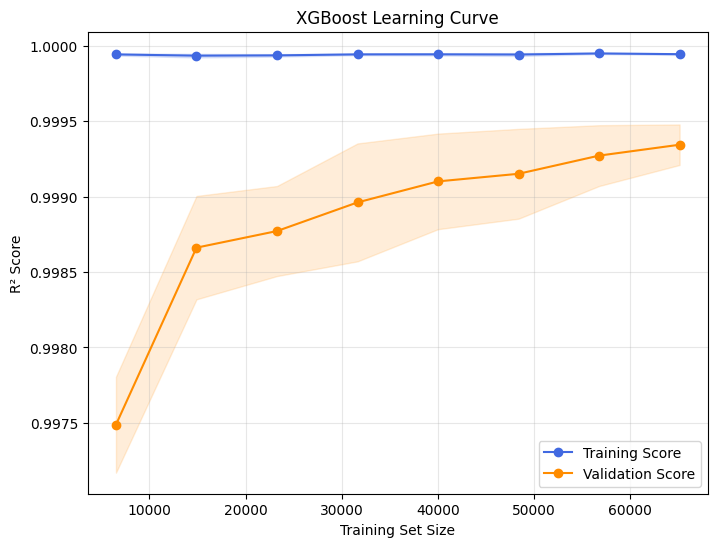

In [21]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, val_scores = learning_curve(
    xgb_best,
    X_train,
    y_train,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 8)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, label="Training Score", color="royalblue", marker="o")
plt.plot(train_sizes, val_mean, label="Validation Score", color="darkorange", marker="o")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.15, color="royalblue")
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.15, color="darkorange")
plt.title("XGBoost Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## 13 Feature Importance — XGBoost

Feature importance analysis identifies which clinical or demographic factors have the highest impact on hospital stay prediction.  
Top-ranked features provide insights into the **key drivers** influencing hospital duration.


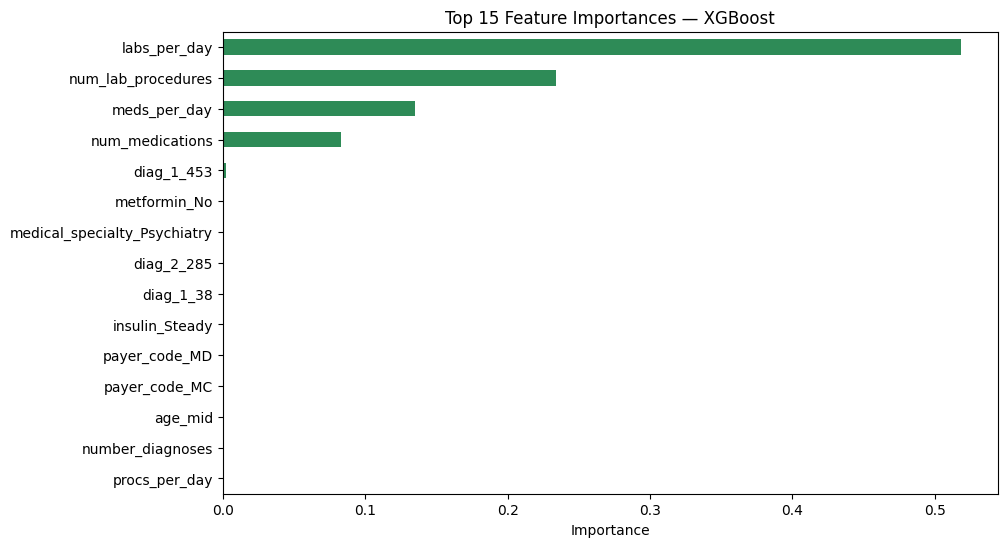

['labs_per_day',
 'num_lab_procedures',
 'meds_per_day',
 'num_medications',
 'diag_1_453',
 'metformin_No',
 'medical_specialty_Psychiatry',
 'diag_2_285',
 'diag_1_38',
 'insulin_Steady',
 'payer_code_MD',
 'payer_code_MC',
 'age_mid',
 'number_diagnoses',
 'procs_per_day']

In [22]:
import pandas as pd

importances_xgb = pd.Series(xgb_best.feature_importances_, index=X_train.columns)
top_xgb = importances_xgb.sort_values(ascending=False).head(15)

plt.figure(figsize=(10,6))
top_xgb.plot(kind="barh", color="seagreen")
plt.title("Top 15 Feature Importances — XGBoost")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()

top_xgb.index.tolist()


## 14 Partial Dependence Plot (PDP) — XGBoost

Partial Dependence Plots illustrate the **marginal effect** of a given feature on the predicted outcome,  
while holding other features constant.  
This allows interpretability by visualizing how changes in specific variables affect hospital stay predictions.


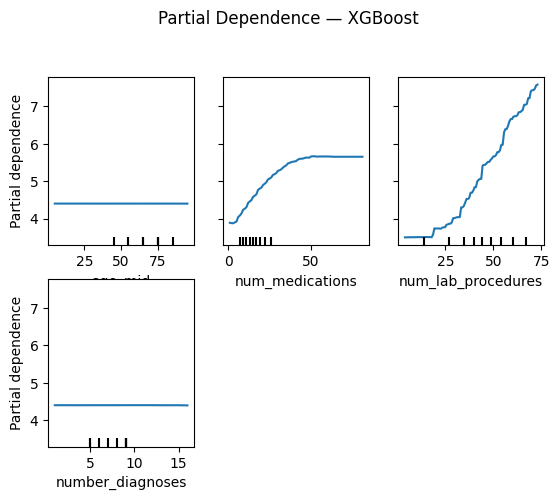

In [23]:
from sklearn.inspection import PartialDependenceDisplay

candidate_feats = [
    "age_mid",
    "num_medications",
    "num_lab_procedures",
    "number_diagnoses",
    "labs_per_day",
    "A1Cresult__7",
    "A1Cresult__8",
    "gender_Male"
]

pdp_feats = [f for f in candidate_feats if f in X_train.columns][:4]
if not pdp_feats:
    pdp_feats = importances_xgb.sort_values(ascending=False).head(4).index.tolist()

fig = PartialDependenceDisplay.from_estimator(
    xgb_best,
    X_train,
    features=pdp_feats,
    kind="average",
    n_jobs=-1
)
fig.figure_.suptitle("Partial Dependence — XGBoost", y=1.02)
plt.show()


## 15 Learning Curve — LightGBM

The learning curve for the tuned LightGBM model shows how performance (R²)  
evolves as the size of the training set increases.

A small gap between training and validation curves indicates good generalization,  
while a large gap would point to potential overfitting.


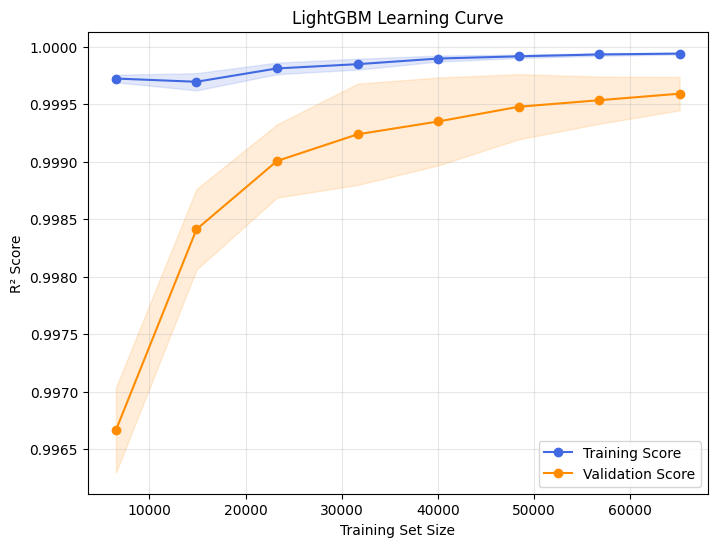

In [24]:
train_sizes, train_scores, val_scores = learning_curve(
    lgbm_best,
    X_train,
    y_train,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 8)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, label="Training Score", color="royalblue", marker="o")
plt.plot(train_sizes, val_mean, label="Validation Score", color="darkorange", marker="o")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.15, color="royalblue")
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.15, color="darkorange")
plt.title("LightGBM Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## 16 Feature Importance — LightGBM

To understand what drives the model’s predictions,  
we inspect the top 15 most important features according to LightGBM.

These features highlight which clinical and operational variables  
contribute the most to hospital stay duration in the final model.


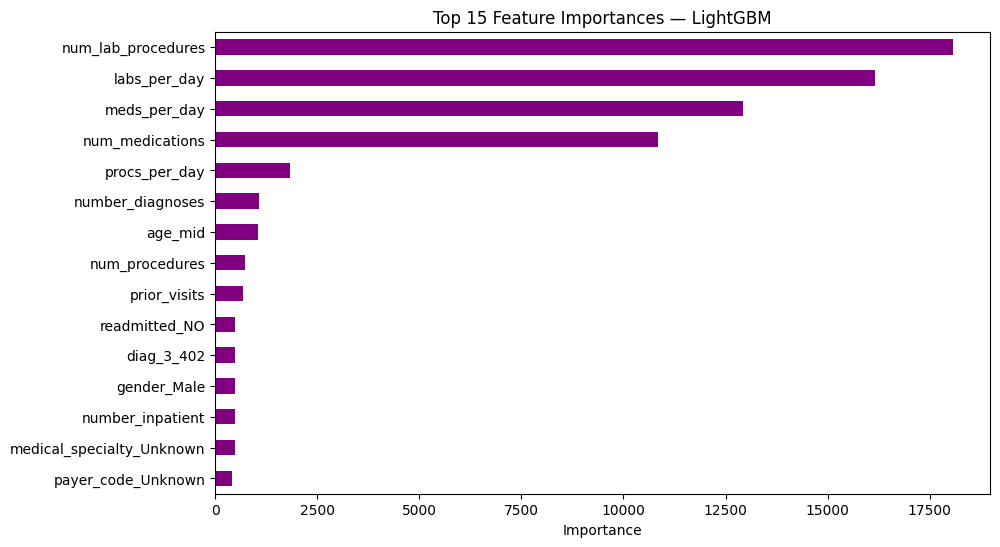

['num_lab_procedures',
 'labs_per_day',
 'meds_per_day',
 'num_medications',
 'procs_per_day',
 'number_diagnoses',
 'age_mid',
 'num_procedures',
 'prior_visits',
 'readmitted_NO',
 'diag_3_402',
 'gender_Male',
 'number_inpatient',
 'medical_specialty_Unknown',
 'payer_code_Unknown']

In [25]:
importances_lgbm = pd.Series(lgbm_best.feature_importances_, index=X_train.columns)
top_lgbm = importances_lgbm.sort_values(ascending=False).head(15)

plt.figure(figsize=(10,6))
top_lgbm.plot(kind="barh", color="purple")
plt.title("Top 15 Feature Importances — LightGBM")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()

top_lgbm.index.tolist()


## 17 Partial Dependence Plots — LightGBM

Partial Dependence Plots (PDPs) show the average effect of selected features  
on the predicted hospital stay, while marginalizing over all other variables.

This provides an interpretable view of how changes in key features  
(e.g. medication count, lab procedures, age) influence the model’s predictions.


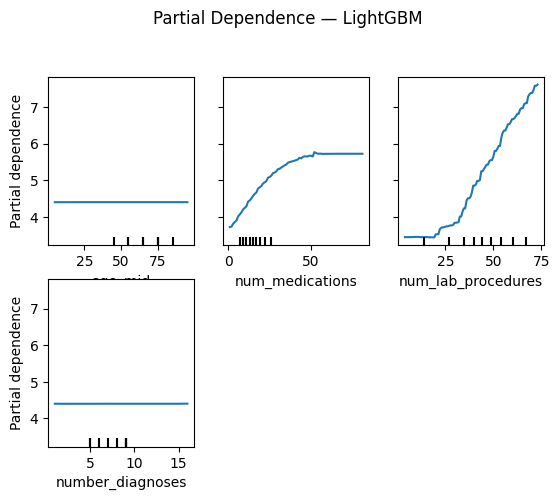

In [26]:
candidate_feats = [
    "age_mid",
    "num_medications",
    "num_lab_procedures",
    "number_diagnoses",
    "labs_per_day",
    "A1Cresult__7",
    "A1Cresult__8",
    "gender_Male"
]

pdp_feats = [f for f in candidate_feats if f in X_train.columns][:4]
if not pdp_feats:
    pdp_feats = importances_lgbm.sort_values(ascending=False).head(4).index.tolist()

fig = PartialDependenceDisplay.from_estimator(
    lgbm_best,
    X_train,
    features=pdp_feats,
    kind="average",
    n_jobs=-1
)
fig.figure_.suptitle("Partial Dependence — LightGBM", y=1.02)
plt.show()


## 18 Save Final Model Artifact

The tuned LightGBM model is saved as a serialized artifact (`.pkl` file)  
so that it can be reused for:

- Inference (batch or real-time scoring)  
- Explainability analysis in a separate notebook  
- Deployment or integration into external applications

The saved model will be loaded in `model_explainability.ipynb`  
for SHAP-based interpretability.


In [30]:
import joblib

final_model = lgbm_best
joblib.dump(final_model, "../models/final_lgbm_model.pkl")
print("✅ Final model saved as ../models/final_lgbm_model.pkl")


✅ Final model saved as ../models/final_lgbm_model.pkl
